In [29]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### MNIST 99.82%

Here we describe our experiment with the venerable MNIST dataset of hand-written digits.

* We reliably get a classification accuracy of 99.82 percent on the ten thousand test images, after training on the sixty-thousand training images.  This is with a committee of 35 neural net classifiers.  Single-net classification accuracy is usually in the mid 99.7 to 99.8 range.

* Each net trains in about three minutes on our GTX-1080ti GPU, with only ten presentations of the training set (ten epochs).

* Along with this notebook, we release the source code of our system, written in Python using PyTorch, so others can reproduce or use our results.

* Finally, we speculate on some aspects of training a classifier with supervised learning that we better appreciate after having done this project.

### Data

In [30]:
from mnist import *
trainset, _, testset = create_mnist_datasets(heldout=0)

Our training dataset includes on-the-fly augmentation.
Each time an image is retrieved, it is randomly cropped
to move it around a little, and also subjected to a small amount
of random rotation, and then a small amount of elastic distortion
is applied.

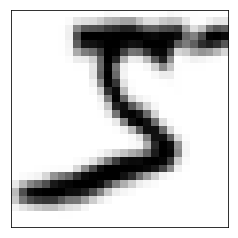

In [183]:
# Here we take the first image in the datset and display it.  To see
# the effect of the augmentation, you can simply refresh this cell
# repeatedly with Ctrl-Enter.
image, label = trainset[0]
show_image(image)

In [198]:
# We set up to retrieve batches at a time.
batcher = Batcher(trainset, bs=144)

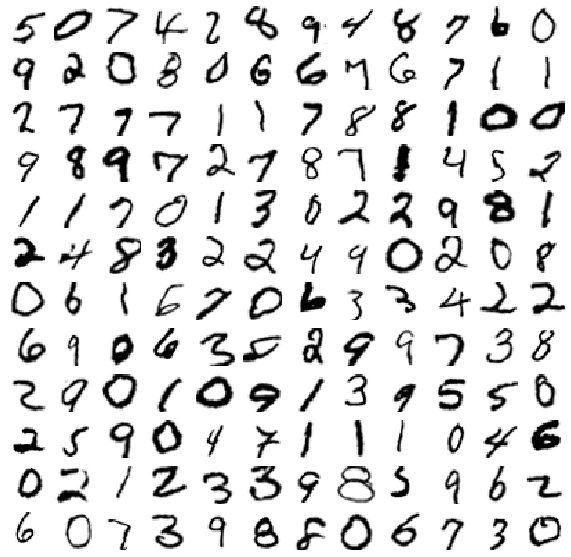

In [201]:
# Display a batch of (augmented) images.  You can refresh 
# this cell with Ctrl-Enter to see additional batches.
images, labels = next(batcher)
plot_images(images)

### Model

Here is the model we use for the MNIST classifier, expressed in PyTorch.

* It is a fairly conventional multilayer convolutional neural net 
with some Resnet-like elements.
* The Residual blocks are ordinary 3x3 convolutions with a shortcut connection going around.
* It makes heavy use of batchnorm, perhaps to a fault.
* It uses old-school maxpool instead of strided convolutions, but we haven't tried the latter.
* It has 7 convolutional layers, including the Residual blocks, which end with 512 4x4 activations.
* These are averaged into a vector of 512 activations, and then a single small dense layer converts those to ten logits output.


```python
class Residual(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.bn = nn.BatchNorm2d(d)
        self.conv3x3 = nn.Conv2d(in_channels=d, out_channels=d,
                                 kernel_size=3, padding=1)

    def forward(self, x):
        x = self.bn(x)
        return x + F.relu(self.conv3x3(x))

def mnist_model():
    "Returns an initialized but untrained model for MNIST."
    return nn.Sequential(
               nn.Conv2d(in_channels=1, out_channels=128, kernel_size=5, padding=2),
               nn.ReLU(),

               Residual(128),
               nn.MaxPool2d(2),
               Residual(128),

               nn.BatchNorm2d(128),
               nn.Conv2d(128, 256, 3, padding=1),
               nn.ReLU(),
               nn.MaxPool2d(2),
               Residual(256),

               nn.BatchNorm2d(256),
               nn.Conv2d(256, 512, 3, padding=1),
               nn.ReLU(),
               nn.MaxPool2d(2, ceil_mode=True),
               Residual(512),

               nn.BatchNorm2d(512),
               nn.AvgPool2d(kernel_size=4),
               Flatten(),

               nn.Linear(512,10),
               # Softmax provided during training.
           )
```

### Training

In [202]:
# These mysterious-looking hyperparameters will be used in
# all of our examples.  Their meaning and how they were
# chosen will be described below.  But first let's just
# use them to train some nets and see how they do.
lr_eff = 0.001
p_max = 0.95
p_min = 0.60
params = {'epochs': 10, 'bs': 100,
          'lr_start': (1.0 - p_max) * lr_eff,
          'lr_middle': (1.0 - p_min) * lr_eff,
          'lr_end': (1.0 - p_min) * (lr_eff / 25),
          'p_start' : p_max,
          'p_middle' : p_min,
          'p_end' : p_min}

In [62]:
def train_one(trainset, testset):
    "Train one instance of our MNIST model."

    model = mnist_model() # untrained
    trainer = Trainer(model, trainset)
    one_cycle(trainer, **params)

    acc, lss = accuracy(Classifier(model), ds=testset, lossftn=nn.CrossEntropyLoss())
    print(f"test set: loss = {lss:.3g}, accuracy = {percent(acc)}")
    return model # trained

In [63]:
m1 = train_one(trainset, testset)

test set: loss = 0.00753, accuracy = 99.77%


That is not bad.  This net trained in about three minutes and the
single-net performance is near the top of those listed on Yann LeCun's
site (see References).

In [37]:
# Let's train four more.
m2 = train_one(trainset, testset)
m3 = train_one(trainset, testset)
m4 = train_one(trainset, testset)
m5 = train_one(trainset, testset)

test set: loss = 0.00763, accuracy = 99.76%


test set: loss = 0.00763, accuracy = 99.77%


test set: loss = 0.0079, accuracy = 99.76%


test set: loss = 0.00751, accuracy = 99.73%


In [39]:
# Wrap each of the trained models into a Classifier object.
classifiers = [Classifier(m) for m in [m1, m2, m3, m4, m5]]
# And combine those classifiers into a committee classifier.
voter = VotingClassifier(classifiers)

# Let's see how it does!
acc = accuracy(voter, ds=testset)
print(f"Committee of {len(classifiers)} accuracy: {percent(acc)}")

Committee of 5 accuracy: 99.81%


This error rate of 0.19 percent is better than the best result on Yann LeCun's site (circa 2012), and also better than the one or two results I've seen published since then.

---

For convenience, we wrote a simple Python script which trains a large population of models and writes them to disk, then chooses random committees from it, with a committee size we specify.

That way we can easily see how different committee sizes perform.  It seems conventional to use a committee of 35, so that is what we use to justify our claim of 99.82 percent accuracy on the test set.

In [42]:
%run committee.py --population 327 --committee 5 --trials 4

Population of 327: training is complete.
1: Committee of 5 accuracy: 99.82%
2: Committee of 5 accuracy: 99.82%
3: Committee of 5 accuracy: 99.78%
4: Committee of 5 accuracy: 99.80%
mean: 99.81% (0.99805)


In [43]:
%run committee.py --population 327 --committee 15 --trials 5

Population of 327: training is complete.
1: Committee of 15 accuracy: 99.81%
2: Committee of 15 accuracy: 99.80%
3: Committee of 15 accuracy: 99.83%
4: Committee of 15 accuracy: 99.84%
5: Committee of 15 accuracy: 99.79%
mean: 99.81% (0.99814)


In [57]:
%run committee.py --population 327 --committee 35 --trials 10

Population of 327: training is complete.
1: Committee of 35 accuracy: 99.82%
2: Committee of 35 accuracy: 99.82%
3: Committee of 35 accuracy: 99.82%
4: Committee of 35 accuracy: 99.81%
5: Committee of 35 accuracy: 99.83%
6: Committee of 35 accuracy: 99.81%
7: Committee of 35 accuracy: 99.82%
8: Committee of 35 accuracy: 99.83%
9: Committee of 35 accuracy: 99.81%
10: Committee of 35 accuracy: 99.82%
mean: 99.82% (0.99819)


**TBD: Show the mistakes!**

**TBD: Explain ELR and how we chose the learning rate.**

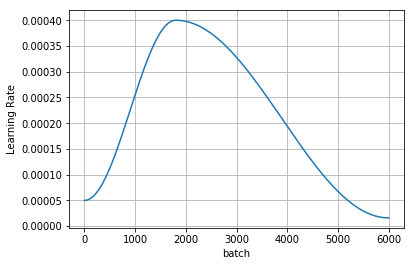

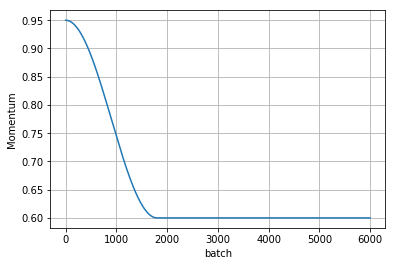

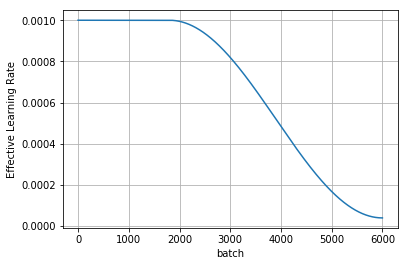

In [64]:
trainer = Trainer(mnist_model(), trainset)
recorder = one_cycle(trainer, **params)
recorder.plot_lr()
recorder.plot_mom()
recorder.plot_elr()

train: stop requested at step 396


<mnist.lr_find.<locals>.LR_Callback at 0x7f49a766ab00>

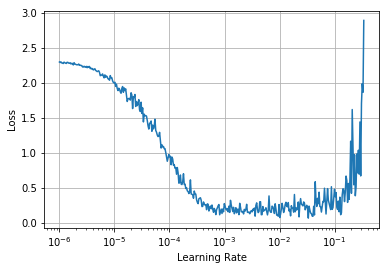

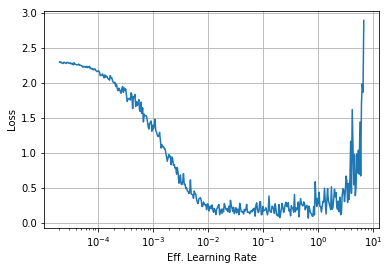

In [68]:
trainer = Trainer(mnist_model(), trainset)
lr_find(trainer, p=p_max, bs=100)

### Thoughts

**TBD: Say what we think is going on.**

**TBD: Say what we think is not going on.**

**TBD: Speculate on the role of one-hot vectors in overfitting**

**TBD: Explain no weight decay.  Mention no dropout.  Talk about fast convergence.**

### References

> Jeremy Howard's [**fast.ai site**](https://www.fast.ai)
and [**fastai library**](https://github.com/fastai/fastai)  
The code we wrote is all in native PyTorch, but many of the
ideas and some of the style is inspired by the new fastai 1.0
library.  We think the library is wonderful, and Jeremy's courses
are a treasure.  The only reason we didn't use fastai directly is that it was just too much fun to write what we needed.  Also, this was an exercise in learning PyTorch.

> Yann LeCun's [**MNIST site**](http://yann.lecun.com/exdb/mnist/)  
It looks like the results have not been updated since about 2012.  So we do not claim that our result is the best out there, only that we think we have a good and interesting result.

> [**A disciplined approach to neural network hyperparameters**](https://arxiv.org/pdf/1803.09820.pdf)  
Leslie N. Smith  
The idea of varying the learning rate and momentum in counterpoise was first described, as far as we can tell, by Leslie Smith.  It was adopted by the fastai library, and we did our own version of it.

> [**Regularization of neural networks using DropConnect**](https://cs.nyu.edu/~wanli/dropc/dropc.pdf)  
Li Wan, Matthew Zeiler, Sixin Zhang, Yann LeCun, and Rob Fergus  
This paper's focus is not on MNIST, but they get a better
result on MNIST than the best result on Yann LeCun's site.  (But not
as good as the result we get here, and they use many more epochs in
training.)